## C_l sampler initial notes and tests

In [1]:
import os
import glob
import sys

import numpy as np
import healpy as hp

from scipy import signal
from scipy.fftpack import fft, fft2, fftshift, fftfreq
from scipy import integrate
from scipy.stats import invgamma

from pygdsm import GlobalSkyModel16
from pygdsm import GlobalSkyModel


# Plotting
#import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib import ticker
# tango colors for colorpairs
sys.path.append("/Users/user/Documents/hera/tango-colors")
# from tango_colors import Tango
# tango = Tango('HTML')
import corner


# HYDRA (for HERA antennas)
sys.path.append("/Users/user/Documents/hera/Hydra") # change this to your own path
import hydra
from hydra.utils import build_hex_array

In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlepad'] = 16
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams["errorbar.capsize"] = 5

## `discrete_cmap()`

In [3]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map

    Notes:
    
    If base_cmap is a string or None, you can simply do return plt.cm.get_cmap(base_cmap, N)
    The following works for string, None, or a colormap instance:
    """

    base = plt.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    
    return base.from_list(cmap_name, color_list, N)

## `plot_ants()`

In [36]:
def plot_ants(radius,ant_pos, 
              # file_name, 
              grid_spacing=1, display=False, ax=None,
             antcolor=None):
    # convert npz file to dict
    ant_dict = dict(ant_pos)

    cmap10_fg = discrete_cmap(10,cmo.dense)
    # cmap10_bg = discrete_cmap(10,cmo.dense)
    if antcolor == None:
        color = cmap10_fg(1)
    else:
        color = antcolor
    bgcolor = 'lavenderblush'#cmap10_fg(1)
    
    # fig, ax = plt.subplots(ncols=1, figsize=(10,6)) 
    for key in ant_dict: 
        ant = ant_dict[key]
        print(ant)
        dish = mpl.patches.Circle(xy=(ant[0], ant[1]),
                                          radius =radius,
                                          zorder=10, color=color,lw=0)
        ax.add_patch(dish)
        if float(key) < 10:
            ax.annotate(key, xy=(ant[0]-0.12,ant[1]-0.14), xycoords='data', zorder=10, fontsize='11')
        else:
            # double digit numbers need more correction
            ax.annotate(key, xy=(ant[0]-0.12,ant[1]-0.12), xycoords='data', zorder=10, fontsize='11')
        plt.axis('equal')
        plt.xlabel('East [ m ]', fontsize='12')
        plt.ylabel('North [ m ]', fontsize='12')

    # Style
    # ax.set_facecolor(bgcolor)
    # ax.spines[:].set_color('white')
        
    # Set tick marks to match grid spacing
    ax.xaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(grid_spacing))
    ax.tick_params(labelsize=12)
    
    plt.grid(color='0.7', ls='-', zorder=0)  
    
    # fig.savefig(file_name+'.png', 
    #         bbox_inches='tight', 
    #         transparent=False, 
    #         dpi=300,#fig.dpi,
    #         facecolor='white')

    # if display == False:
    #     plt.close()

    plt.close()


# Main

In [5]:
# Display available folders
parentpath = '/Users/user/Documents/hera/cl_sampler_analysis/data/'
[file[52:] for file in sorted(glob.glob(parentpath+'*'))]

['04-10-24_vis_response_freq_test_plots',
 '10-10-24_tol_broad',
 '10-10-24_trace_plots',
 '10-10-24_vis_response_freq_test_plots',
 '14-10-24_trace_plots',
 '400MHz_1m',
 '450MHz_1m',
 '500MHz_1m',
 'cl_3m_test',
 'cl_lmax_20',
 'cl_sampler_100',
 'freq_1d_test',
 'trace_plots',
 'vis_response_freq_test_plots']

In [6]:
# Set paths and create figure folder within data folder
path = parentpath+'400MHz_1m/'
figpath = path+'figures/'
if not os.path.isdir(figpath): os.makedirs(figpath)

In [7]:
# Load precomputed data and see which are available
try:
    precomp = np.load(path+'precomputed_data.npz')
except:
    precomp = np.load(path+'precomputed_data_20_1.npz')
precomp.files

['vis_response',
 'autos',
 'x_true',
 'inv_noise_cov',
 'min_prior_std',
 'inv_prior_cov',
 'a_0',
 'data_seed',
 'prior_seed',
 'incl_cosmic_var',
 'wf_soln',
 'nside',
 'lmax',
 'ants',
 'dish_diameter',
 'freqs',
 'lsts_hours',
 'precomp_time']

In [8]:
# Assign precomputed data 
vis_response = precomp['vis_response']
autos = precomp['autos']
x_true = precomp['x_true']
inv_noise_cov = precomp['inv_noise_cov']
min_prior_std = precomp['min_prior_std']
inv_prior_cov = precomp['inv_prior_cov']
a_0 = precomp['a_0']
data_seed = precomp['data_seed']
prior_seed = precomp['prior_seed']
wf_soln = precomp['wf_soln']
nside = precomp['nside']
lmax = precomp['lmax']
dish_diameter = precomp['dish_diameter']
freqs = precomp['freqs']
lsts_hours = precomp['lsts_hours']
precomp_time = precomp['precomp_time']
# avg_iter_time = precomp['avg_iter_time']
# total_time = precomp['total_time']

In [9]:
# print(precomp_time,avg_iter_time, total_time)

In [10]:
# Anttenas had to be in a separate file
ant_pos = np.load(path+'ant_pos.npz')
print(ant_pos.files)

dict_ants = dict(ant_pos)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## baseline length and ell

[-1.5        -1.29903811  0.        ]
[ 0.         -1.29903811  0.        ]
[ 1.5        -1.29903811  0.        ]
[-2.25  0.    0.  ]
[-0.75  0.    0.  ]
[0.75 0.   0.  ]
[2.25 0.   0.  ]
[-1.5         1.29903811  0.        ]
[0.         1.29903811 0.        ]
[1.5        1.29903811 0.        ]


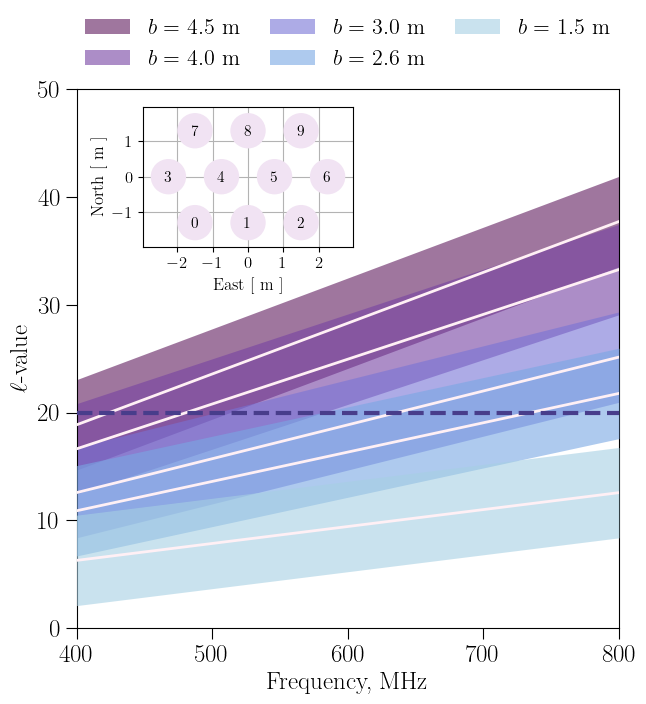

In [40]:
beam_diameter = dish_diameter        # m
speed_of_light = 2.998e08            # m/s
fwhm_rad = speed_of_light/(freqs[0]*beam_diameter)  # radian 
fwhm_deg = np.rad2deg(fwhm_rad)
freq_list = np.linspace(400,800,100)

# The errorbar \delta \ell \simeq np.pi / FWHM(rad) 
delta_ell = np.pi/fwhm_rad 

bl_lengths = np.array([np.linalg.norm(dict_ants['0']-dict_ants['1']), # meters
                       np.linalg.norm(dict_ants['0']-dict_ants['7']),
                       np.linalg.norm(dict_ants['0']-dict_ants['8']),
                       np.linalg.norm(dict_ants['0']-dict_ants['9']),
                       np.linalg.norm(dict_ants['3']-dict_ants['6'])])

   
fig, ax = plt.subplots(ncols=1, figsize=(7,7)) 
cmap5 = discrete_cmap(5, cmocean.tools.crop_by_percent(cmo.dense_r, 30, which='both', N=None))

for i, bl in enumerate(np.flip(bl_lengths)):
    ell_measured = np.pi * bl /(speed_of_light/freq_list)*1e06
    ax.fill_between(freq_list, ell_measured-delta_ell, ell_measured+delta_ell, alpha=0.6, color=cmap5(i), linewidth=0, zorder = i,  label=r'$b=$'+f' {bl:.1f} m')
    ax.plot(freq_list, ell_measured, color='lavenderblush', zorder = 100+i, lw=2)

# ax.axvline(100+0.1,ls="--",color='0.2',lw=2, zorder = 200)  # b (nlsts) 
ax.axhline(20,ls='--', lw=3, color='darkslateblue', zorder = 210)
# ax.axhline(30,ls='--', lw=2, color='purple', zorder = 200)
# ax.axhspan(20, 50, color='white', alpha=0.4, lw=0, zorder=200) # shaded version


ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", #title='Baseline length',
               mode="expand", borderaxespad=0, ncol=3,frameon=False, fontsize=16)


plt.xlabel('Frequency, MHz')
plt.ylabel(r'$\ell$-value')
ax.set_xlim([freq_list[0],freq_list[-1]])
ax.set_ylim([0,50])
ax.tick_params(length=8)

# create new axes for insert of correlation matrix
extra_ax_1 = fig.add_axes([0.22, 0.655, 0.3, 0.2])  #lbwh non shaded version
# extra_ax_1 = fig.add_axes([0.22, 0.6, 0.35, 0.25])  #lbwh shaded version


plot_ants(radius=dish_diameter/2,
             ant_pos=ant_pos,
             ax=extra_ax_1, grid_spacing=1.,
         antcolor='#F1E3F3')

fig.savefig(figpath+'baseline_vs_ell'+'.pdf', 
        bbox_inches='tight', 
        transparent=False, 
        dpi=300,#fig.dpi,
        facecolor='white')


fig